<a href="https://colab.research.google.com/github/marioklau/Klasifikasi-Suara-Burung-eksperimen-/blob/main/Eks_CNN_Klasifikasi_Suara_Burung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library

In [1]:
!pip install tensorflow==2.12.0


In [2]:
!pip install librosa

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("Setup complete!")

Mounted at /content/drive
Setup complete!


In [4]:
print(tf.__version__)

2.12.0


## Definisi Path Dataset dan Label

In [5]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Birds2'

LABELS = [
    label for label in sorted(os.listdir(DATA_PATH))
         if os.path.isdir(os.path.join(DATA_PATH, label))]

print(f"Menggunakan dataset dari: {DATA_PATH}")
print(f"Label yang akan dikenali: {LABELS}")

Menggunakan dataset dari: /content/drive/MyDrive/Colab Notebooks/Deep Learning/Birds2
Label yang akan dikenali: ['Alor Boobook', 'Arafura Fantail', 'Ashy-bellied White-eye', 'Banded Fruit Dove', 'Bare-throated Whistler', 'Cinereous Tit']


## Ekstraksi Fitur (MFCCs) dari Audio

In [6]:
def extract_features(file_path, max_pad_len=38):
    try:

        audio, sample_rate = librosa.load(file_path, sr=None)

        # Resample to a common sample rate if necessary (e.g., 16000 Hz)
        # This is crucial for consistency across files
        target_sample_rate = 16000
        if sample_rate != target_sample_rate:
            audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=target_sample_rate)
            sample_rate = target_sample_rate

        # Ensure consistent audio length (e.g., 1 second)
        # Pad or trim audio to a fixed length
        target_len_samples = int(target_sample_rate * 45.0) # 1 second audio
        if len(audio) < target_len_samples:
            # Pad if shorter
            pad_width = target_len_samples - len(audio)
            audio = np.pad(audio, (0, pad_width), 'constant')
        else:
            # Trim if longer
            audio = audio[:target_len_samples]

        # Extract MFCCs
        # n_mfcc: Number of MFCCs to return
        # n_fft: Window size for STFT
        # hop_length: Number of samples between successive frames
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, n_fft=2048, hop_length=512)

        # Pad MFCCs to a consistent length (max_pad_len)
        # This handles slight variations in audio duration after fixed-length slicing
        if mfccs.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

    return mfccs

# Fungsi untuk memuat semua data audio dan labelnya
def load_audio_data(data_path, labels):
    all_features = []
    all_labels = []
    skipped_files = 0
    total_files = 0

    for label in labels:
        label_path = os.path.join(data_path, label)
        if not os.path.isdir(label_path):
            print(f"Peringatan: Folder '{label_path}' tidak ditemukan. Melewati label ini.")
            continue

        print(f"Memproses label: {label}")
        for filename in os.listdir(label_path):
            if filename.endswith('.mp3'):
                file_path = os.path.join(label_path, filename)
                total_files += 1
                features = extract_features(file_path)
                if features is not None:
                    all_features.append(features)
                    all_labels.append(label)
                else:
                    skipped_files += 1

    print(f"\nSelesai memproses data. Total file: {total_files}, File yang dilewati: {skipped_files}")
    return np.array(all_features), np.array(all_labels)

# Muat data
X, y = load_audio_data(DATA_PATH, LABELS)



Memproses label: Alor Boobook
Memproses label: Arafura Fantail
Memproses label: Ashy-bellied White-eye
Memproses label: Banded Fruit Dove
Memproses label: Bare-throated Whistler
Memproses label: Cinereous Tit

Selesai memproses data. Total file: 116, File yang dilewati: 0


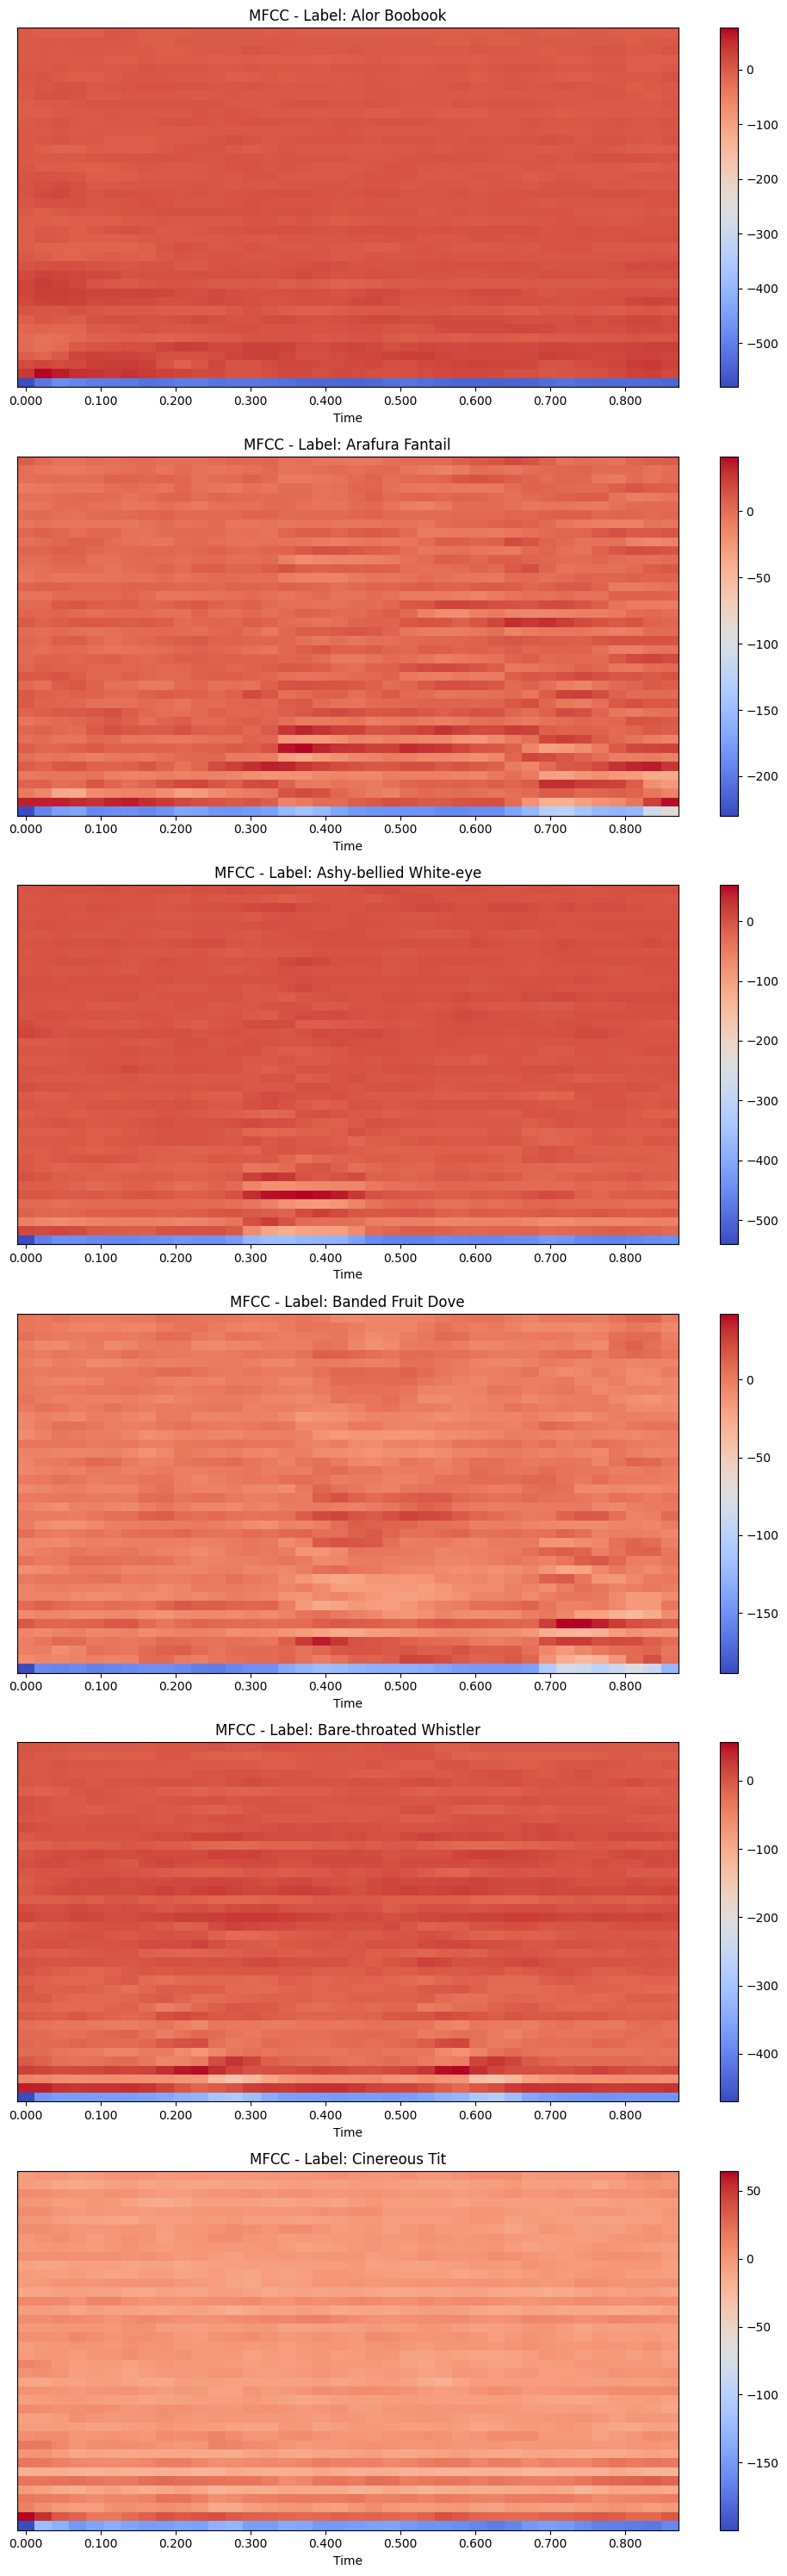

In [8]:
import random

def plot_mfcc_per_label(X, y, labels, num_samples=1):
    plt.figure(figsize=(10, 5 * len(labels)))
    for i, label in enumerate(labels):
        # Ambil index dari semua data dengan label tertentu
        label_indices = np.where(y == label)[0]
        if len(label_indices) == 0:
            print(f"Tidak ada data untuk label: {label}")
            continue

        # Ambil 1 sample acak dari label ini
        sample_index = random.choice(label_indices)
        mfcc = X[sample_index]

        plt.subplot(len(labels), num_samples, i + 1)
        librosa.display.specshow(mfcc, x_axis='time')
        plt.colorbar()
        plt.title(f'MFCC - Label: {label}')
        plt.tight_layout()

    plt.show()

# Panggil fungsi untuk menampilkan MFCC
plot_mfcc_per_label(X, y, LABELS)

In [9]:
if len(X) == 0:
    print("Tidak dapat melanjutkan. Tidak ada data fitur yang dimuat.")
else:
    # Encode label teks menjadi numerik
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)
    print(f"Kelas yang ditemukan: {label_encoder.classes_}")
    print(f"Jumlah kelas: {num_classes}")

    # One-hot encode label numerik
    y_categorical = to_categorical(y_encoded, num_classes=num_classes)

    # Membagi data menjadi training dan testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)

    # Menambahkan dimensi channel (1 untuk grayscale/mono audio features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    print(f"Bentuk X_train: {X_train.shape}")
    print(f"Bentuk X_test: {X_test.shape}")
    print(f"Bentuk y_train: {y_train.shape}")
    print(f"Bentuk y_test: {y_test.shape}")

Kelas yang ditemukan: ['Alor Boobook' 'Arafura Fantail' 'Ashy-bellied White-eye'
 'Banded Fruit Dove' 'Bare-throated Whistler' 'Cinereous Tit']
Jumlah kelas: 6
Bentuk X_train: (92, 40, 38, 1)
Bentuk X_test: (24, 40, 38, 1)
Bentuk y_train: (92, 6)
Bentuk y_test: (24, 6)


## Buat Model

In [13]:
from tensorflow.keras.layers import Input

# Dapatkan bentuk input dari data pelatihan
input_shape = X_train.shape[1:]

model = Sequential([
    Input(shape=input_shape),  # Explicit Input layer
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(), # Menggantikan Flatten untuk lebih robust
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 40, 38, 32)        320       
                                                                 
 batch_normalization_5 (Batc  (None, 40, 38, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 19, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 20, 19, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 19, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 20, 19, 64)      

In [14]:
# Kompilasi model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks untuk pelatihan
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_speech_command_model.h5', # Simpan di Google Drive
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Pelatihan model
epochs = 50
batch_size = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("\nPelatihan selesai!")

Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 3.1043 - accuracy: 0.2391
Epoch 1: val_accuracy improved from -inf to 0.08333, saving model to /content/drive/MyDrive/best_speech_command_model.h5
3/3 [==============================] - 5s 643ms/step - loss: 3.1043 - accuracy: 0.2391 - val_loss: 2.1481 - val_accuracy: 0.0833
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 2.4256 - accuracy: 0.1630
Epoch 2: val_accuracy improved from 0.08333 to 0.20833, saving model to /content/drive/MyDrive/best_speech_command_model.h5
3/3 [==============================] - 1s 241ms/step - loss: 2.4256 - accuracy: 0.1630 - val_loss: 2.1230 - val_accuracy: 0.2083
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 2.2361 - accuracy: 0.2935
Epoch 3: val_accuracy improved from 0.20833 to 0.33333, saving model to /content/drive/MyDrive/best_speech_command_model.h5
3/3 [==============================] - 1s 211ms/step - loss: 2.2361 - accuracy: 0.2935 - val_loss

Akurasi model pada data pengujian: 20.83%
Loss model pada data pengujian: 2.1230


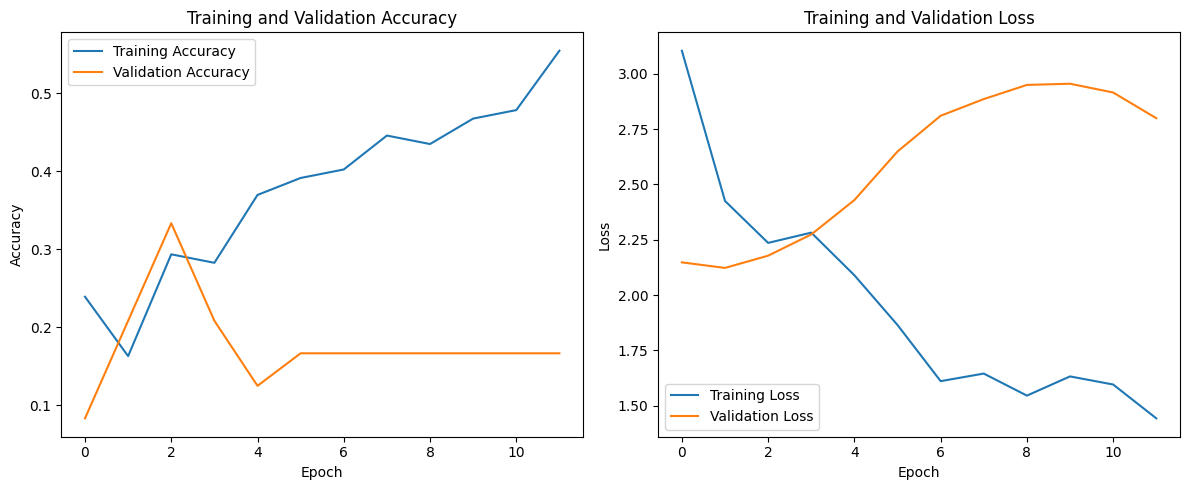

In [15]:
# Evaluasi model pada test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Akurasi model pada data pengujian: {accuracy*100:.2f}%")
print(f"Loss model pada data pengujian: {loss:.4f}")

# Plot history pelatihan
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Muat model terbaik yang disimpan
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/best_speech_command_model.h5')
print("Model terbaik berhasil dimuat!")

# Fungsi untuk memprediksi file audio tunggal
def predict_audio(file_path, model, label_encoder, max_pad_len=38):
    # Check if the path is a file
    if not os.path.isfile(file_path):
        print(f"Error: Path '{file_path}' is not a file.")
        return None, None, None

    # Extract features - handle different return formats
    features_result = extract_features(file_path, max_pad_len)

    # Case 1: If features_result is a tuple/list (multiple returns)
    if isinstance(features_result, (tuple, list)):
        features = features_result[0]  # Take first element as features
    # Case 2: If single value returned
    else:
        features = features_result

    if features is None:
        return "Gagal memproses audio.", None, None

    # Tambahkan dimensi batch dan channel
    features = features[np.newaxis, ..., np.newaxis]

    # Prediksi
    predictions = model.predict(features)
    predicted_class_index = np.argmax(predictions[0])
    predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]
    confidence = predictions[0][predicted_class_index]

    return predicted_label, confidence, predictions[0]


# Path audio contoh
sample_audio_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_speech/stop/dca2797e_nohash_3.wav'

if os.path.exists(sample_audio_path):
    predicted_label, confidence, all_predictions = predict_audio(sample_audio_path, loaded_model, label_encoder)
    if predicted_label: # Check if prediction was successful
        print(f"\nAudio: {os.path.basename(sample_audio_path)}")
        print(f"Prediksi: {predicted_label} dengan keyakinan {confidence*100:.2f}%")
        print("Distribusi probabilitas untuk semua kelas:")
        for i, prob in enumerate(all_predictions):
            print(f"  {label_encoder.inverse_transform([i])[0]}: {prob*100:.2f}%")
else:
    print(f"\nFile audio uji tidak ditemukan di: {sample_audio_path}. Mohon ganti path.")

In [ ]:

from IPython.display import Audio # For playing audio (optional)

def extract_features(file_path, max_pad_len=38):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)
        target_sample_rate = 16000
        if sample_rate != target_sample_rate:
            audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=target_sample_rate)
            sample_rate = target_sample_rate

        target_len_samples = int(target_sample_rate * 1.0)
        if len(audio) < target_len_samples:
            pad_width = target_len_samples - len(audio)
            audio = np.pad(audio, (0, pad_width), 'constant')
        else:
            audio = audio[:target_len_samples]

        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40, n_fft=2048, hop_length=512)

        if mfccs.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None

    return mfccs, audio, sample_rate


# Define the predict_audio_from_file function
def predict_audio_from_file(file_path, model, label_encoder, max_pad_len=38):
    features, audio_signal, sample_rate = extract_features(file_path, max_pad_len)
    if features is None:
        return "Gagal memproses audio.", None, None, None, None

    # Add batch and channel dimensions
    input_features = features[np.newaxis, ..., np.newaxis]

    # Predict
    predictions = model.predict(input_features)
    predicted_class_index = np.argmax(predictions[0])
    predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]
    confidence = predictions[0][predicted_class_index]

    return predicted_label, confidence, predictions[0], audio_signal, sample_rate

print("Fungsi predict_audio_from_file dan extract_features telah didefinisikan.")

## Uji Model


--- Memproses file: e9b61425_nohash_1.wav ---
1/1 [==============================] - 0s 30ms/step
Prediksi: **stop** dengan keyakinan **99.99%**

Distribusi probabilitas untuk semua kelas:
  go: 0.01%
  stop: 99.99%

Memutar kembali audio yang diuji:


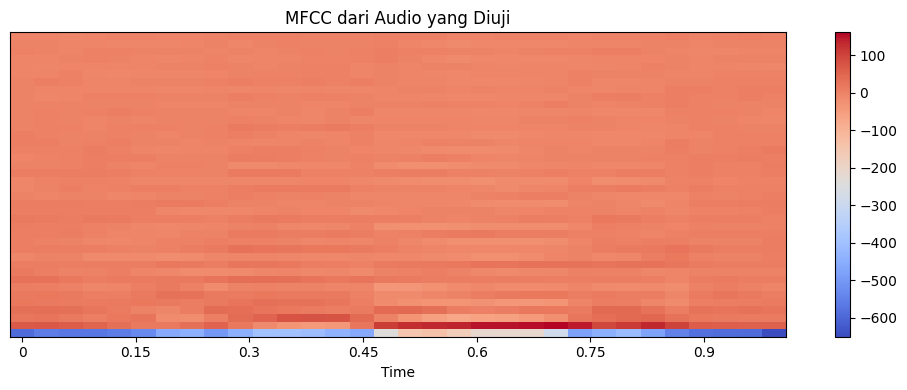

In [ ]:
# TEST_AUDIO_FILE = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_speech/go/0a9f9af7_nohash_1.wav'
TEST_AUDIO_FILE = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_speech/stop/e9b61425_nohash_1.wav'

if not os.path.exists(TEST_AUDIO_FILE):
    print(f"Error: File audio '{TEST_AUDIO_FILE}' tidak ditemukan.")
    print("Pastikan path file audio Anda benar di Google Drive.")
else:
    print(f"\n--- Memproses file: {os.path.basename(TEST_AUDIO_FILE)} ---")
    predicted_label, confidence, all_predictions, audio_signal, sample_rate = \
        predict_audio_from_file(TEST_AUDIO_FILE, loaded_model, label_encoder)

    if predicted_label:
        print(f"Prediksi: **{predicted_label}** dengan keyakinan **{confidence*100:.2f}%**")
        print("\nDistribusi probabilitas untuk semua kelas:")
        for i, prob in enumerate(all_predictions):
            print(f"  {label_encoder.inverse_transform([i])[0]}: {prob*100:.2f}%")

        # Opsional: Putar kembali audio yang diuji
        print("\nMemutar kembali audio yang diuji:")
        display(Audio(data=audio_signal, rate=sample_rate))

        # Opsional: Visualisasi MFCC dari audio yang diuji
        import matplotlib.pyplot as plt
        import librosa.display

        plt.figure(figsize=(10, 4))
        # Ekstrak MFCC lagi untuk visualisasi (tanpa padding/trimming ekstra yang mungkin sudah dilakukan)
        # Gunakan audio_signal yang sudah diproses di dalam fungsi predict_audio_from_file
        mfccs_to_display = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=40, n_fft=2048, hop_length=512)
        librosa.display.specshow(mfccs_to_display, x_axis='time', sr=sample_rate)
        plt.colorbar()
        plt.title('MFCC dari Audio yang Diuji')
        plt.tight_layout()
        plt.show()
    else:
        print("Prediksi gagal. Silakan periksa pesan error di atas.")

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
model.save("model_speech2.keras")
